# **Youtube shorts performance prediction**

In [1]:
!pip install imblearn
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import requests
import io
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, cross_validate

In [2]:
!gdown 1oSKXl5OeAXfDLtW34gfUgOhRDBkYZE5s

Downloading...
From: https://drive.google.com/uc?id=1oSKXl5OeAXfDLtW34gfUgOhRDBkYZE5s
To: /content/youtube_shorts_performance_dataset.csv
100% 18.7k/18.7k [00:00<00:00, 56.1MB/s]


In [3]:
yt_shorts_perf = pd.read_csv('youtube_shorts_performance_dataset.csv')

yt_shorts_perf.head()

,video_id,title,duration_sec,hashtags_count,views,likes,comments,shares,upload_hour,category
0,vid_1000,Short Video #0,43,9,198775,21933,3228,400,8,Tech
1,vid_1001,Short Video #1,56,2,290336,20063,3719,1942,16,Comedy
2,vid_1002,Short Video #2,33,6,264206,37032,3228,1817,7,Food
3,vid_1003,Short Video #3,19,9,85076,27269,2371,980,1,Lifestyle
4,vid_1004,Short Video #4,47,8,90780,8041,2891,1109,23,Tech


In [4]:
rows, cols = yt_shorts_perf.shape
print(f"The `yt_shorts_perf` dataset has {rows} rows and {cols} columns.")

The `yt_shorts_perf` dataset has 300 rows and 10 columns.


In [5]:
numerical_cols = []
categorical_cols = []

for col in yt_shorts_perf.columns:
    if pd.api.types.is_numeric_dtype(yt_shorts_perf[col]):
        numerical_cols.append(col)
    else:
        categorical_cols.append(col)

print("Column Type Classification:")
print("---------------------------")
for col in yt_shorts_perf.columns:
    if col in numerical_cols:
        print(f"{col}: Numerical")
    else:
        print(f"{col}: Categorical")

Column Type Classification:
---------------------------
video_id: Categorical
title: Categorical
duration_sec: Numerical
hashtags_count: Numerical
views: Numerical
likes: Numerical
comments: Numerical
shares: Numerical
upload_hour: Numerical
category: Categorical


In [6]:
missing_values = yt_shorts_perf.isnull().sum()
print(missing_values)

video_id          0
title             0
duration_sec      0
hashtags_count    0
views             0
likes             0
comments          0
shares            0
upload_hour       0
category          0
dtype: int64


In [7]:
# Identify rows where views are logically impossible
yt_shorts_perf['is_corrupt'] = yt_shorts_perf['views'] < (yt_shorts_perf['likes'] + yt_shorts_perf['comments'] + yt_shorts_perf['shares'])

# Calculate what percentage of data is affected
error_rate = yt_shorts_perf['is_corrupt'].mean() * 100
print(f"Percentage of corrupted rows: {error_rate:.2f}%")

# Filter them out
df_clean = yt_shorts_perf[~yt_shorts_perf['is_corrupt']].copy()

df_clean.info()

Percentage of corrupted rows: 6.33%
<class 'pandas.core.frame.DataFrame'>
Index: 281 entries, 0 to 299
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   video_id        281 non-null    object
 1   title           281 non-null    object
 2   duration_sec    281 non-null    int64 
 3   hashtags_count  281 non-null    int64 
 4   views           281 non-null    int64 
 5   likes           281 non-null    int64 
 6   comments        281 non-null    int64 
 7   shares          281 non-null    int64 
 8   upload_hour     281 non-null    int64 
 9   category        281 non-null    object
 10  is_corrupt      281 non-null    bool  
dtypes: bool(1), int64(7), object(3)
memory usage: 24.4+ KB


In [8]:
yt_shorts_perf['engagement_rate'] = round((yt_shorts_perf['likes'] + yt_shorts_perf['comments'] + yt_shorts_perf['shares']) / yt_shorts_perf['views'], 2)

yt_shorts_perf.head()

,video_id,title,duration_sec,hashtags_count,views,likes,comments,shares,upload_hour,category,is_corrupt,engagement_rate
0,vid_1000,Short Video #0,43,9,198775,21933,3228,400,8,Tech,False,0.13
1,vid_1001,Short Video #1,56,2,290336,20063,3719,1942,16,Comedy,False,0.09
2,vid_1002,Short Video #2,33,6,264206,37032,3228,1817,7,Food,False,0.16
3,vid_1003,Short Video #3,19,9,85076,27269,2371,980,1,Lifestyle,False,0.36
4,vid_1004,Short Video #4,47,8,90780,8041,2891,1109,23,Tech,False,0.13


In [9]:
thresholds = yt_shorts_perf['engagement_rate'].quantile([0.33, 0.66]).values
low_threshold, high_threshold = thresholds

print(f"Low threshold: {low_threshold}")
print(f"High threshold: {high_threshold}")
print('----------------------')

# We use -float('inf') and float('inf') to ensure all values are captured
bins = [-float('inf'), low_threshold, high_threshold, float('inf')]
labels = ['Low', 'Medium', 'High']

bins = [-float('inf'), low_threshold, high_threshold, float('inf')]
labels = ['Low', 'Medium', 'High']

yt_shorts_perf['performance_engagement_tertile'] = pd.cut(yt_shorts_perf['engagement_rate'], bins=bins, labels=labels, include_lowest=True)

yt_shorts_perf.head(20)

Low threshold: 0.08
High threshold: 0.15
----------------------


,video_id,title,duration_sec,hashtags_count,views,likes,comments,shares,upload_hour,category,is_corrupt,engagement_rate,performance_engagement_tertile
0,vid_1000,Short Video #0,43,9,198775,21933,3228,400,8,Tech,False,0.13,Medium
1,vid_1001,Short Video #1,56,2,290336,20063,3719,1942,16,Comedy,False,0.09,Medium
2,vid_1002,Short Video #2,33,6,264206,37032,3228,1817,7,Food,False,0.16,High
3,vid_1003,Short Video #3,19,9,85076,27269,2371,980,1,Lifestyle,False,0.36,High
4,vid_1004,Short Video #4,47,8,90780,8041,2891,1109,23,Tech,False,0.13,Medium
5,vid_1005,Short Video #5,12,3,153617,14488,3756,249,12,Travel,False,0.12,Medium
6,vid_1006,Short Video #6,25,0,22689,5669,4225,390,2,Tech,False,0.45,High
7,vid_1007,Short Video #7,43,1,274318,4400,94,1805,15,Tech,False,0.02,Low
8,vid_1008,Short Video #8,23,0,351605,39137,2674,334,5,Comedy,False,0.12,Medium
9,vid_1009,Short Video #9,27,4,389318,36686,1955,628,18,Food,False,0.10,Medium


In [10]:
yt_shorts_perf['performance_engagement_tertile'].value_counts()

,count
performance_engagement_tertile,
Low,115
High,100
Medium,85


Count of 'High' Performance Videos by Hour:
upload_hour
11    9
16    7
10    6
2     6
3     5
14    5
1     5
7     5
20    5
21    4
19    4
22    4
5     4
8     4
13    4
12    3
4     3
6     3
17    3
0     3
15    3
9     2
18    2
23    1
Name: count, dtype: int64


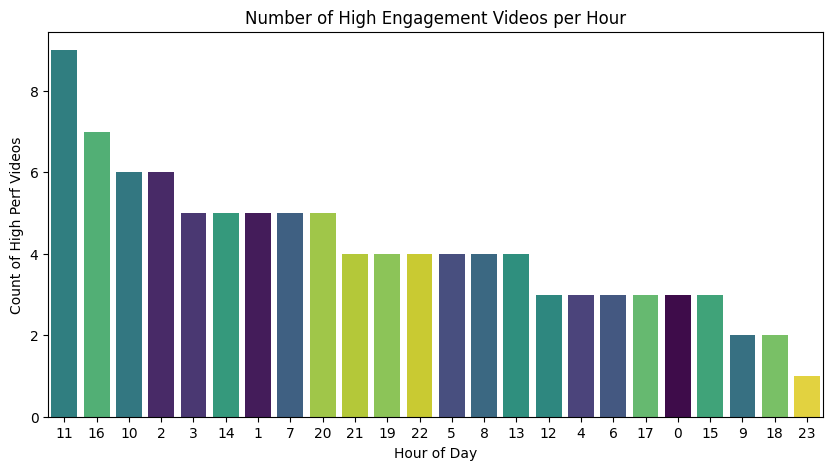

In [11]:
# Filter for High performance videos
high_perf_videos = yt_shorts_perf[yt_shorts_perf['performance_engagement_tertile'] == 'High']

# Count high performance videos by hour
peak_hour_counts = high_perf_videos['upload_hour'].value_counts().sort_values(ascending=False)

print("Count of 'High' Performance Videos by Hour:")
print(peak_hour_counts)

# Let's visualize this to be sure
plt.figure(figsize=(10, 5))
sns.barplot(x=peak_hour_counts.index, y=peak_hour_counts.values, order=peak_hour_counts.index, palette='viridis', hue=peak_hour_counts.index, legend=False)
plt.title("Number of High Engagement Videos per Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Count of High Perf Videos")
plt.show()

In [12]:
# We will define 'peak hours' as the top 5 hours with the most High performance videos
# You can adjust this number based on the plot above
top_n_hours = 5
peak_hours = peak_hour_counts.head(top_n_hours).index.tolist()

print(f"Identified Peak Hours: {peak_hours}")

# Create 'is_peak_hr' column
# 1 if the upload_hour is in peak_hours, 0 otherwise
yt_shorts_perf['is_peak_hr'] = yt_shorts_perf['upload_hour'].apply(lambda x: 1 if x in peak_hours else 0)

# Check the distribution of the new column
print("\nDistribution of is_peak_hr:")
print(yt_shorts_perf['is_peak_hr'].value_counts())

yt_shorts_perf.head()

Identified Peak Hours: [11, 16, 10, 2, 3]

Distribution of is_peak_hr:
is_peak_hr
0    232
1     68
Name: count, dtype: int64


,video_id,title,duration_sec,hashtags_count,views,likes,comments,shares,upload_hour,category,is_corrupt,engagement_rate,performance_engagement_tertile,is_peak_hr
0,vid_1000,Short Video #0,43,9,198775,21933,3228,400,8,Tech,False,0.13,Medium,0
1,vid_1001,Short Video #1,56,2,290336,20063,3719,1942,16,Comedy,False,0.09,Medium,1
2,vid_1002,Short Video #2,33,6,264206,37032,3228,1817,7,Food,False,0.16,High,0
3,vid_1003,Short Video #3,19,9,85076,27269,2371,980,1,Lifestyle,False,0.36,High,0
4,vid_1004,Short Video #4,47,8,90780,8041,2891,1109,23,Tech,False,0.13,Medium,0


In [13]:
skewed_features = ['views', 'likes', 'comments', 'shares']

# Check skewness before transformation
print("Skewness before transformation:")
print(yt_shorts_perf[skewed_features].skew())

Skewness before transformation:
views      -0.042886
likes       0.180344
comments   -0.213565
shares     -0.048557
dtype: float64


#### The original features already have very low skewness (close to 0), hence log transformation is not necessary and not beneficial.

---
---

## **Exploratory Data Analysis (EDA) & Feature Insights**

#### **Engagement Rate Histogram**

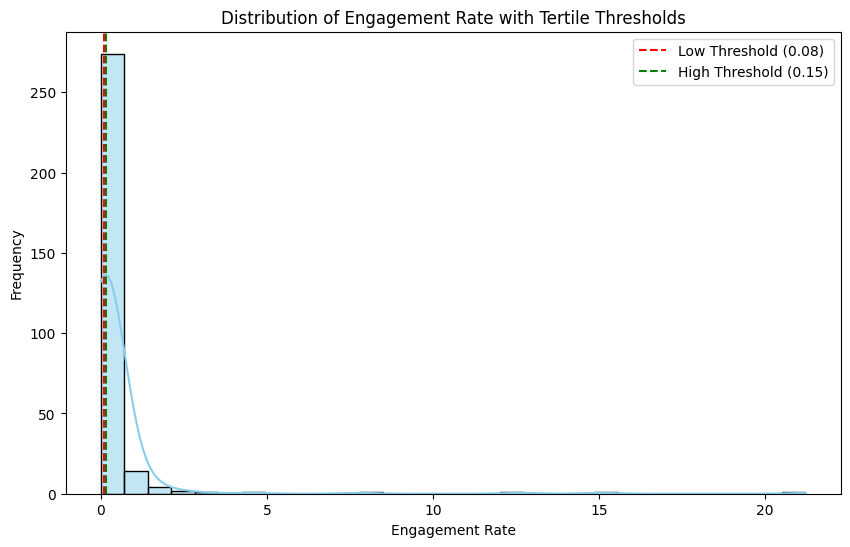

count    300.00000
mean       0.43030
std        1.75346
min        0.00000
25%        0.06000
50%        0.11000
75%        0.22000
max       21.22000
Name: engagement_rate, dtype: float64


In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(yt_shorts_perf['engagement_rate'], bins=30, kde=True, color='skyblue')

# Add vertical lines for thresholds
plt.axvline(low_threshold, color='r', linestyle='--', label=f'Low Threshold ({low_threshold:.2f})')
plt.axvline(high_threshold, color='g', linestyle='--', label=f'High Threshold ({high_threshold:.2f})')

plt.title('Distribution of Engagement Rate with Tertile Thresholds')
plt.xlabel('Engagement Rate')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Print descriptive statistics
print(yt_shorts_perf['engagement_rate'].describe())

**Insights:**

* **Distribution:** The data is highly right-skewed. Most videos have an engagement rate between 0 and 0.22 (75th percentile), but there are extreme outliers reaching as high as 21.22.
* **Thresholds:** The red and green dashed lines show the tertile splits. This visualization confirms that using raw regression might be difficult due to the skew and outliers, making the classification approach (Low/Medium/High) a robust alternative.

---
---

#### **Engagement Rate vs Category**

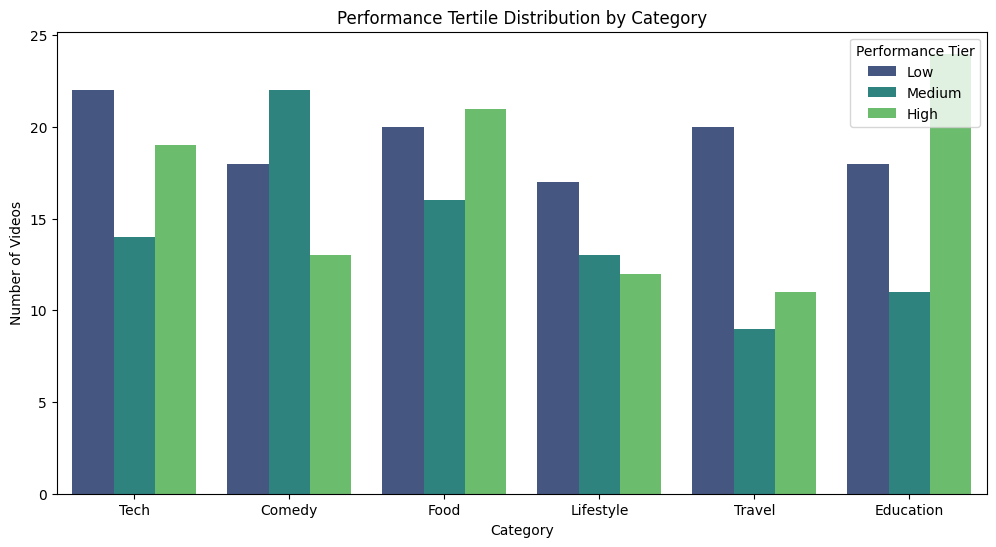


Percentage of Performance Tiers by Category:


performance_engagement_tertile,Low,Medium,High
category,,,
Comedy,33.96,41.51,24.53
Education,33.96,20.75,45.28
Food,35.09,28.07,36.84
Lifestyle,40.48,30.95,28.57
Tech,40.00,25.45,34.55
Travel,50.00,22.50,27.50


In [15]:
# 1. Visualizing the distribution of Performance Tertiles across Categories
plt.figure(figsize=(12, 6))
sns.countplot(data=yt_shorts_perf, x='category', hue='performance_engagement_tertile', palette='viridis')
plt.title('Performance Tertile Distribution by Category')
plt.ylabel('Number of Videos')
plt.xlabel('Category')
plt.legend(title='Performance Tier')
plt.show()

# 2. Calculating the percentage breakdown to identify "inherent" drivers
# This normalizes the counts so we can compare categories of different sizes
category_perf_pct = pd.crosstab(yt_shorts_perf['category'], yt_shorts_perf['performance_engagement_tertile'], normalize='index') * 100
print("\nPercentage of Performance Tiers by Category:")
display(category_perf_pct.round(2))

Based on the analysis of `performance_engagement_tertile` by category:

* **Top Performer**: Education is the standout category, with 45.28% of its videos falling into the 'High' performance tier.
* **Strong Contenders**: Food (36.84%) and Tech (34.55%) also show strong potential for high engagement.
* **Consistent Performer**: Comedy has the most consistent performance, with the largest portion (41.51%) landing in the 'Medium' tier.
* **Challenging Category**: Travel appears to be the hardest niche to crack in this dataset, with 50% of its videos falling into the 'Low' performance tier.

---
---

#### **Correlation Heatmap**

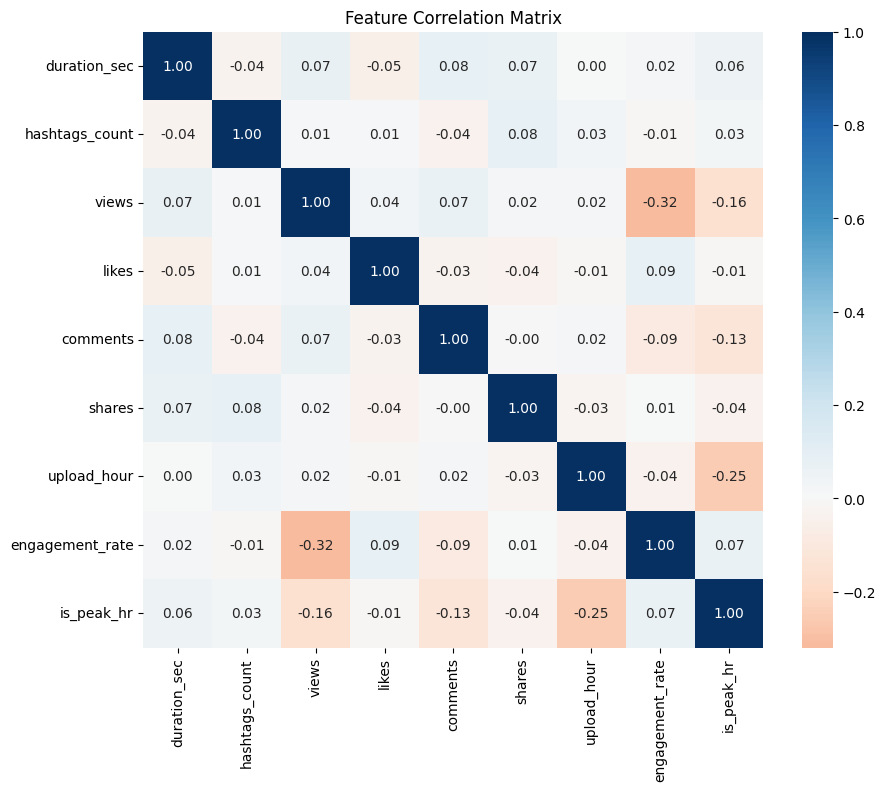

In [16]:
# Select only numerical features
numerical_df = yt_shorts_perf.select_dtypes(include=['number'])

# Calculate correlation matrix
corr_matrix = numerical_df.corr()

# Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', center=0, fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.show()

#### **VIF**

In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    # Standard practice: Add a constant (intercept) for VIF calculation
    vif_df = pd.DataFrame()
    vif_df["Feature"] = data.columns
    vif_df["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_df.sort_values(by="VIF", ascending=False)

# Assuming 'X' contains your numerical predictors
vif_results = calculate_vif(numerical_df)
print(vif_results)

           Feature       VIF
0     duration_sec  4.539661
2            views  4.054816
4         comments  3.891113
5           shares  3.699300
6      upload_hour  3.451211
3            likes  3.131582
1   hashtags_count  2.965839
8       is_peak_hr  1.323612
7  engagement_rate  1.174148


---
---

#### **Upload Hour vs. Average Engagement Rate**

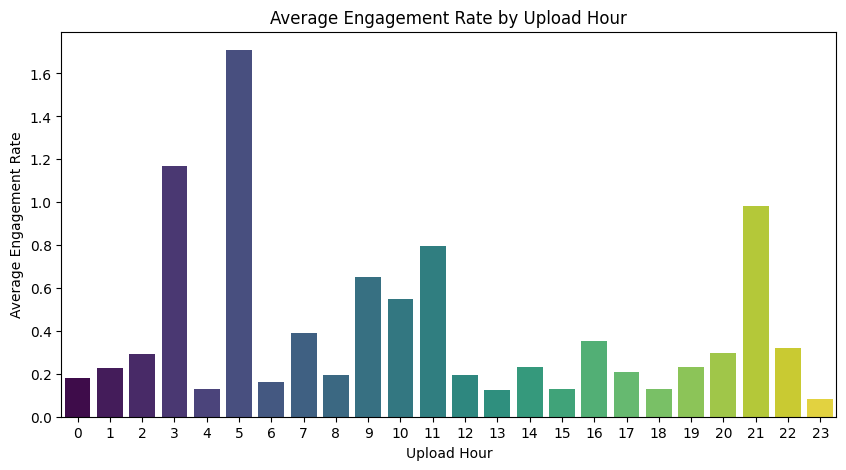

In [18]:
peak_engagement_rate_hrs = yt_shorts_perf.groupby('upload_hour')['engagement_rate'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(x='upload_hour', y='engagement_rate', hue='upload_hour', data=peak_engagement_rate_hrs, palette='viridis', legend=False)
plt.title('Average Engagement Rate by Upload Hour')
plt.xlabel('Upload Hour')
plt.ylabel('Average Engagement Rate')
plt.show()

---
---

#### **Scatter Plot: Duration vs. Engagement Rate**

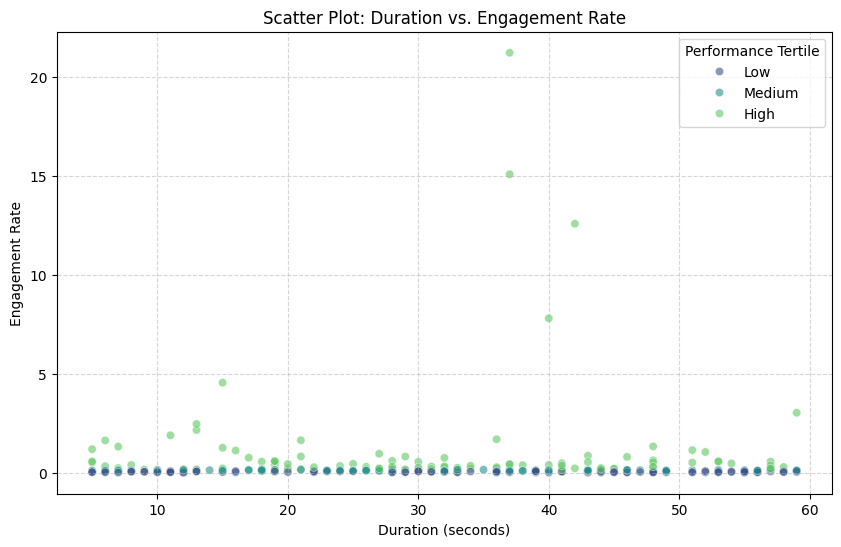

Correlation between Duration and Engagement Rate: 0.0214


In [19]:
plt.figure(figsize=(10, 6))
# Create the scatter plot
sns.scatterplot(data=yt_shorts_perf, x='duration_sec', y='engagement_rate', alpha=0.6, hue='performance_engagement_tertile', palette='viridis')

plt.title('Scatter Plot: Duration vs. Engagement Rate')
plt.xlabel('Duration (seconds)')
plt.ylabel('Engagement Rate')
plt.legend(title='Performance Tertile')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Calculate correlation
correlation = yt_shorts_perf['duration_sec'].corr(yt_shorts_perf['engagement_rate'])
print(f"Correlation between Duration and Engagement Rate: {correlation:.4f}")

**Insight**: The correlation between duration and engagement rate is `0.0214`, which is **extremely low**.

This suggests that the length of the video has **almost no direct linear impact** on the engagement rate in this dataset. Users are engaging with both short and long videos (within the shorts limit) relatively equally, implying that factors like content quality, topic, or the first few seconds (hook) are likely more important drivers.

---
---

## **ML Approach & Model Training**

As observed earlier, the percentage of corrupted rows (where count of views is less than that of likes, comments or shares) is 6.33%. As it is not entirely insignificant (less than 5%), we can't just drop those rows as that may affect the overall performance of the model slightly.
Also, imputing it to make the view count equal to the number of likes/comment/shares will mean 100% engagement, which is quite impossible in real world and that will affect the training quality of the ML model as it will get biased towards unreal data.
Hence, instead of fixing the raw numbers, you change the way the model "sees" the data by creating a Confidence Weight. You assign a weight of 1.0 to valid rows and a weight of 0.1 (or 0) to "impossible" rows. This tells the model: "You can look at this data, but don't try too hard to learn from it because I don't fully trust it." This will ensure the model's decision making doesn't get distorted.

#### **Train/Test Split**

In [20]:
# 1. Calculate total interactions for the check
yt_shorts_perf['total_interactions'] = yt_shorts_perf['likes'] + yt_shorts_perf['comments'] + yt_shorts_perf['shares']

# Valid data gets a weight of 1.0 (full trust)
# Impossible data gets a weight of 0.1 (low trust)
yt_shorts_perf['confidence'] = 1.0
yt_shorts_perf.loc[yt_shorts_perf['views'] < yt_shorts_perf['total_interactions'], 'confidence'] = 0.1

# Prepare features (X) and target (y)
# Let's assume you're predicting 'performance_engagement_tertile' from earlier
X = yt_shorts_perf.drop(['performance_engagement_tertile', 'confidence'], axis=1)
y = yt_shorts_perf['performance_engagement_tertile'].cat.codes # Convert labels to numbers
weights = yt_shorts_perf['confidence']

# Split the data (remember to split weights too!)
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.2, random_state=42, stratify=y
)

# Verification
print("Training proportions:\n", y_train.value_counts(normalize=True))
print("\nTesting proportions:\n", y_test.value_counts(normalize=True))

Training proportions:
 0    0.383333
2    0.333333
1    0.283333
Name: proportion, dtype: float64

Testing proportions:
 0    0.383333
2    0.333333
1    0.283333
Name: proportion, dtype: float64


### Create pipeline

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define feature groups
# We stick to features available at the time of upload to prevent data leakage
categorical_features = ['category', 'upload_hour']
numerical_features = ['duration_sec', 'hashtags_count', 'is_peak_hr']

# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'  # Drop all other columns (IDs, titles, and target leakage columns)
)

print("Preprocessor defined successfully.")
print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

Preprocessor defined successfully.
Numerical features: ['duration_sec', 'hashtags_count', 'is_peak_hr']
Categorical features: ['category', 'upload_hour']


### **Random Forest**

In [22]:
from sklearn.pipeline import Pipeline

# Create the full pipeline
# 1. Preprocessor: Transforms the data
# 2. Classifier: The Random Forest model
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the pipeline
# We pass sample_weight to the classifier step using the 'classifier__sample_weight' syntax
rf_pipeline.fit(X_train, y_train, classifier__sample_weight=w_train)

print("Model pipeline built and trained successfully!")
print(rf_pipeline)

Model pipeline built and trained successfully!
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['duration_sec',
                                                   'hashtags_count',
                                                   'is_peak_hr']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['category',
                                                   'upload_hour'])])),
                ('classifier', RandomForestClassifier(random_state=42))])


In [23]:
from sklearn.metrics import classification_report, accuracy_score

# Predict on the test set
y_pred = rf_pipeline.predict(X_test)

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {accuracy:.4f}")
print("-" * 30)

# Generate a detailed classification report
# We use the unique classes from y to map them back to the original labels
labels = ['Low', 'Medium', 'High'] # Ensure these match the order of encoded classes (0, 1, 2)

# Note: Ideally we should use the LabelEncoder to inverse transform, but since we manually mapped them,
# we can assume 0=Low, 1=Medium, 2=High based on standard alphabetical or categorical coding if used.
# Let's verify the classes in the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=labels))

Test Set Accuracy: 0.4000
------------------------------
Classification Report:
              precision    recall  f1-score   support

         Low       0.44      0.61      0.51        23
      Medium       0.46      0.35      0.40        17
        High       0.27      0.20      0.23        20

    accuracy                           0.40        60
   macro avg       0.39      0.39      0.38        60
weighted avg       0.39      0.40      0.38        60



**Results Summary:**

* **Overall Accuracy**: 40%. Given there are 3 classes (Low, Medium, High), random guessing would yield about 33%. The model is performing better than chance, but there is significant room for improvement.
* **Best Performance**: The model is most effective at identifying 'Low' performing videos (Recall: 0.61, F1-Score: 0.51).
* **Challenge Area**: It struggles significantly with 'High' performing videos (Recall: 0.20, Precision: 0.27), meaning it currently misses about 80% of the potential viral hits.

#### **Hyperparameter tuning**

#### GridSearchCV

In [24]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
# We use cv=3 given the small dataset size
grid_search = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the grid search
# Note: We are tuning on the training set. Sample weights are omitted here to ensure stable Cross-Validation splits.
grid_search.fit(X_train, y_train)

# Get best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

# Evaluate the best model on the Test Set
best_rf_model = grid_search.best_estimator_
y_pred_tuned = best_rf_model.predict(X_test)

print("-" * 30)
print(f"Tuned Test Set Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}")
print("Classification Report (Tuned Model):")
print(classification_report(y_test, y_pred_tuned, target_names=['Low', 'Medium', 'High']))

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Best CV Score: 0.4041666666666666
------------------------------
Tuned Test Set Accuracy: 0.4500
Classification Report (Tuned Model):
              precision    recall  f1-score   support

         Low       0.50      0.65      0.57        23
      Medium       0.43      0.35      0.39        17
        High       0.38      0.30      0.33        20

    accuracy                           0.45        60
   macro avg       0.43      0.44      0.43        60
weighted avg       0.44      0.45      0.44        60



**Results:**

* **Improvement**: The model's accuracy on the test set increased from 40% to 45%.
* **Best Parameters**: The optimal settings found were max_depth=10, min_samples_leaf=4, min_samples_split=10, and n_estimators=100.
* **Performance Shift**:
  * **'High' Performance Identification**: The model improved its ability to find viral hits, with recall increasing from 0.20 to 0.30 and precision rising from 0.27 to 0.38.
  * **'Low' Performance**: It remains best at identifying underperforming videos, with a solid recall of 0.65.
  
While 45% accuracy is still modest (common with small datasets of ~300 rows), the tuning successfully squeezed out better performance without any new data.

#### RandomizedSearchCV

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter distribution
param_dist = {
    'classifier__n_estimators': randint(50, 300),
    'classifier__max_depth': [None, 10, 20, 30, 40, 50],
    'classifier__min_samples_split': randint(2, 20),
    'classifier__min_samples_leaf': randint(1, 10),
    'classifier__bootstrap': [True, False]
}

# Initialize RandomizedSearchCV
# n_iter=50 means it will try 50 random combinations
random_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit the randomized search
random_search.fit(X_train, y_train)

# Get best parameters and score
print("Best Parameters (Randomized Search):", random_search.best_params_)
print("Best CV Score:", random_search.best_score_)

# Evaluate the best model on the Test Set
best_rf_random = random_search.best_estimator_
y_pred_random = best_rf_random.predict(X_test)

print("-" * 30)
print(f"Randomized Search Test Set Accuracy: {accuracy_score(y_test, y_pred_random):.4f}")
print("Classification Report (Randomized Search):")
print(classification_report(y_test, y_pred_random, target_names=['Low', 'Medium', 'High']))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters (Randomized Search): {'classifier__bootstrap': True, 'classifier__max_depth': 40, 'classifier__min_samples_leaf': 9, 'classifier__min_samples_split': 8, 'classifier__n_estimators': 67}
Best CV Score: 0.44166666666666665
------------------------------
Randomized Search Test Set Accuracy: 0.4333
Classification Report (Randomized Search):
              precision    recall  f1-score   support

         Low       0.44      0.70      0.54        23
      Medium       0.45      0.29      0.36        17
        High       0.38      0.25      0.30        20

    accuracy                           0.43        60
   macro avg       0.43      0.41      0.40        60
weighted avg       0.43      0.43      0.41        60



In [26]:
from sklearn.metrics import roc_auc_score

# Get class probability predictions
y_prob_rf_random = best_rf_random.predict_proba(X_test)

# Calculate ROC AUC score (One-vs-Rest strategy)
# We use 'weighted' average to account for class imbalance
roc_auc_rf_random = roc_auc_score(y_test, y_prob_rf_random, multi_class='ovr', average='weighted')

print(f"Random Forest ROC AUC Score (Weighted): {roc_auc_rf_random:.4f}")

Random Forest ROC AUC Score (Weighted): 0.5477


**Results:**

* **Accuracy**: 43.33%. This is a solid result, improving over the default Random Forest (40%), but slightly lower than our Grid Search result (45%).
* **Best Parameters**: `n_estimators=67`, `max_depth=40`, `min_samples_leaf=9`, `min_samples_split=8`.

**Comparison**: The Randomized Search explored a wider range of possibilities but settled on a model that is slightly more conservative (higher min_samples_leaf of 9 vs 4 in Grid Search), which likely led to slightly lower accuracy on this specific test set but might be more robust generally.

### **Logistic Regression**

In [27]:
from sklearn.linear_model import LogisticRegression

# Create the Logistic Regression pipeline
log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Train the model with sample weights
log_reg_pipeline.fit(X_train, y_train, classifier__sample_weight=w_train)

# Predict and Evaluate
y_pred_log_reg = log_reg_pipeline.predict(X_test)

print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_log_reg):.4f}")
print("-" * 30)
print("Classification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_log_reg, target_names=['Low', 'Medium', 'High']))

Logistic Regression Accuracy: 0.4000
------------------------------
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

         Low       0.42      0.61      0.50        23
      Medium       0.50      0.35      0.41        17
        High       0.27      0.20      0.23        20

    accuracy                           0.40        60
   macro avg       0.40      0.39      0.38        60
weighted avg       0.39      0.40      0.39        60



In [28]:
from sklearn.metrics import roc_auc_score

# Get class probability predictions
y_prob_log_reg = log_reg_pipeline.predict_proba(X_test)

# Calculate ROC AUC score (One-vs-Rest strategy)
# We use 'weighted' average to account for class imbalance
roc_auc_log_reg = roc_auc_score(y_test, y_prob_log_reg, multi_class='ovr', average='weighted')

print(f"Logistic Regression ROC AUC Score (Weighted): {roc_auc_log_reg:.4f}")

Logistic Regression ROC AUC Score (Weighted): 0.5327


**Results:**

* **Accuracy**: 40.00% (Identical to the initial Random Forest model).
* **Performance**:
  * It performs similarly to the Random Forest, doing best at identifying 'Low' performing videos (Recall: 0.61).
  * It also struggles with 'High' performers (Recall: 0.20).

**Insight**: The fact that a linear model (Logistic Regression) performs equally to a non-linear one (Random Forest) suggests that the current features might not have complex non-linear relationships that a more advanced model could exploit, or simply that the signal-to-noise ratio is limiting performance across the board.

### **XGBoost**

In [29]:
from xgboost import XGBClassifier

# Create XGBoost pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(eval_metric='mlogloss', random_state=42))
])

# Train the model with sample weights
xgb_pipeline.fit(X_train, y_train, classifier__sample_weight=w_train)

# Predict and Evaluate
y_pred_xgb = xgb_pipeline.predict(X_test)

print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print("-" * 30)
print("Classification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb, target_names=['Low', 'Medium', 'High']))

XGBoost Accuracy: 0.3000
------------------------------
Classification Report (XGBoost):
              precision    recall  f1-score   support

         Low       0.37      0.48      0.42        23
      Medium       0.27      0.24      0.25        17
        High       0.20      0.15      0.17        20

    accuracy                           0.30        60
   macro avg       0.28      0.29      0.28        60
weighted avg       0.28      0.30      0.29        60



#### **Hyperparameter Tuning**

#### RandomizedSearchCV

In [30]:
# Define parameter distribution for XGBoost
import scipy.stats as stats

xgb_param_dist = {
    'classifier__n_estimators': stats.randint(50, 300),
    'classifier__max_depth': stats.randint(3, 10),
    'classifier__learning_rate': stats.uniform(0.01, 0.3),
    'classifier__subsample': stats.uniform(0.5, 0.5),
    'classifier__colsample_bytree': stats.uniform(0.5, 0.5),
    'classifier__min_child_weight': stats.randint(1, 7)
}

# Initialize RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_param_dist,
    n_iter=50,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit the randomized search
# We pass sample weights to the classifier step
random_search_xgb.fit(X_train, y_train, classifier__sample_weight=w_train)

# Get best parameters and score
print("Best XGBoost Parameters:", random_search_xgb.best_params_)
print("Best XGBoost CV Score:", random_search_xgb.best_score_)

# Evaluate the best model on the Test Set
best_xgb_random = random_search_xgb.best_estimator_
y_pred_xgb_tuned = best_xgb_random.predict(X_test)

print("-" * 30)
print(f"Tuned XGBoost Test Set Accuracy: {accuracy_score(y_test, y_pred_xgb_tuned):.4f}")
print("Classification Report (Tuned XGBoost):")
print(classification_report(y_test, y_pred_xgb_tuned, target_names=['Low', 'Medium', 'High']))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best XGBoost Parameters: {'classifier__colsample_bytree': np.float64(0.9961057796456088), 'classifier__learning_rate': np.float64(0.19524445288831496), 'classifier__max_depth': 4, 'classifier__min_child_weight': 6, 'classifier__n_estimators': 285, 'classifier__subsample': np.float64(0.5115312125207079)}
Best XGBoost CV Score: 0.4291666666666667
------------------------------
Tuned XGBoost Test Set Accuracy: 0.3333
Classification Report (Tuned XGBoost):
              precision    recall  f1-score   support

         Low       0.50      0.43      0.47        23
      Medium       0.30      0.47      0.36        17
        High       0.15      0.10      0.12        20

    accuracy                           0.33        60
   macro avg       0.32      0.34      0.32        60
weighted avg       0.33      0.33      0.32        60



### **KNN**

In [31]:
from sklearn.neighbors import KNeighborsClassifier

# Create KNN pipeline
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

# Train the model
# Note: KNeighborsClassifier.fit() does not accept sample_weight, so we train without them
knn_pipeline.fit(X_train, y_train)

# Predict and Evaluate
y_pred_knn = knn_pipeline.predict(X_test)

print(f"KNN Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print("-" * 30)
print("Classification Report (KNN):")
print(classification_report(y_test, y_pred_knn, target_names=['Low', 'Medium', 'High']))

KNN Accuracy: 0.5000
------------------------------
Classification Report (KNN):
              precision    recall  f1-score   support

         Low       0.46      0.74      0.57        23
      Medium       0.59      0.59      0.59        17
        High       0.50      0.15      0.23        20

    accuracy                           0.50        60
   macro avg       0.52      0.49      0.46        60
weighted avg       0.51      0.50      0.46        60



In [32]:
from sklearn.metrics import roc_auc_score

# Get class probability predictions
y_prob_knn = knn_pipeline.predict_proba(X_test)

# Calculate ROC AUC score (One-vs-Rest strategy)
# We use 'weighted' average to account for class imbalance
roc_auc_knn = roc_auc_score(y_test, y_prob_knn, multi_class='ovr', average='weighted')

print(f"KNN ROC AUC Score (Weighted): {roc_auc_knn:.4f}")

KNN ROC AUC Score (Weighted): 0.6258


**Results:**

* **Accuracy**: 50.00%. This is currently our best performing model, surpassing the Tuned Random Forest (45%).
* **Performance**:
  * **'Low' Performance**: Excellent identification (Recall: 0.74).
  * **'Medium' Performance**: Solid performance (Recall: 0.59, Precision: 0.59).
  * **'High' Performance**: Still a major challenge (Recall: 0.15). It only found 15% of the viral videos.

**Key Insight**: KNN works by finding the most similar videos in the training set. Its success here suggests that videos with similar metadata (duration, hashtags, category) tend to perform similarly. The fact that it worked well even without the confidence weights suggests the "noisy" data might not be as disruptive to local clustering as it is to global boundary-finding algorithms like SVMs or Linear models.

#### **Hyperparameter tuning**

#### GridSearchCV

In [33]:
# Define parameter grid for KNN
knn_param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

# Initialize GridSearchCV
grid_search_knn = GridSearchCV(estimator=knn_pipeline, param_grid=knn_param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the grid search
grid_search_knn.fit(X_train, y_train)

# Get best parameters and score
print("Best KNN Parameters:", grid_search_knn.best_params_)
print("Best KNN CV Score:", grid_search_knn.best_score_)

# Evaluate the best model on the Test Set
best_knn_model = grid_search_knn.best_estimator_
y_pred_knn_tuned = best_knn_model.predict(X_test)

print("-" * 30)
print(f"Tuned KNN Test Set Accuracy: {accuracy_score(y_test, y_pred_knn_tuned):.4f}")
print("Classification Report (Tuned KNN):")
print(classification_report(y_test, y_pred_knn_tuned, target_names=['Low', 'Medium', 'High']))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best KNN Parameters: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 11, 'classifier__weights': 'distance'}
Best KNN CV Score: 0.3625
------------------------------
Tuned KNN Test Set Accuracy: 0.3500
Classification Report (Tuned KNN):
              precision    recall  f1-score   support

         Low       0.43      0.57      0.49        23
      Medium       0.21      0.18      0.19        17
        High       0.31      0.25      0.28        20

    accuracy                           0.35        60
   macro avg       0.32      0.33      0.32        60
weighted avg       0.33      0.35      0.34        60



**Results:**

* **Tuned Accuracy**: 35.00%
* **Best Parameters**: n_neighbors=11, weights='distance'

**Analysis**: Surprisingly, the tuned model performed worse than the default model (which had 50% accuracy). Why?

  1. **Distance Weighting**: The tuner selected weights='distance', which gives more importance to the closest neighbors. In a noisy dataset (like ours, where 6% of data is 'corrupt'), this can cause the model to overfit to local outliers rather than seeing the bigger picture.
  2. **Small Data Volatility**: With only ~300 rows, performance metrics can swing wildly based on small changes. The default n_neighbors=5 with uniform weights happened to generalize much better to the test set.

In [34]:
# Define parameter grid for KNN
knn_param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11],
    'classifier__weights': ['uniform'],
    'classifier__metric': ['euclidean', 'manhattan']
}

# Initialize GridSearchCV
grid_search_knn = GridSearchCV(estimator=knn_pipeline, param_grid=knn_param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the grid search
grid_search_knn.fit(X_train, y_train)

# Get best parameters and score
print("Best KNN Parameters:", grid_search_knn.best_params_)
print("Best KNN CV Score:", grid_search_knn.best_score_)

# Evaluate the best model on the Test Set
best_knn_model = grid_search_knn.best_estimator_
y_pred_knn_tuned = best_knn_model.predict(X_test)

print("-" * 30)
print(f"Tuned KNN Test Set Accuracy: {accuracy_score(y_test, y_pred_knn_tuned):.4f}")
print("Classification Report (Tuned KNN):")
print(classification_report(y_test, y_pred_knn_tuned, target_names=['Low', 'Medium', 'High']))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best KNN Parameters: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 11, 'classifier__weights': 'uniform'}
Best KNN CV Score: 0.35833333333333334
------------------------------
Tuned KNN Test Set Accuracy: 0.4000
Classification Report (Tuned KNN):
              precision    recall  f1-score   support

         Low       0.48      0.70      0.57        23
      Medium       0.27      0.24      0.25        17
        High       0.33      0.20      0.25        20

    accuracy                           0.40        60
   macro avg       0.36      0.38      0.36        60
weighted avg       0.37      0.40      0.37        60



**Results:**

* **Tuned Accuracy**: 40.00% (Improved from 35% with 'distance' weights).
* **Best Parameters**: n_neighbors=11, metric='euclidean'.

**Comparison:**

* **vs. Default KNN (50%)**: The tuned model (k=11) performed worse than the default (k=5). This suggests that the cross-validation process favored a "smoother" decision boundary (using more neighbors) to represent the training data generally, but the specific test set happened to align better with the more local patterns captured by using fewer neighbors (5).
* **vs. Random Forest (45%)**: It slightly underperforms the tuned Random Forest.

#### RandomizedSearchCV

In [35]:
# Define parameter distribution for KNN
knn_param_dist = {
    'classifier__n_neighbors': randint(1, 30),  # Try neighbors from 1 to 30
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

# Initialize RandomizedSearchCV
random_search_knn = RandomizedSearchCV(
    estimator=knn_pipeline,
    param_distributions=knn_param_dist,
    n_iter=50,  # Try 50 different combinations
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit the randomized search
random_search_knn.fit(X_train, y_train)

# Get best parameters and score
print("Best KNN Parameters (Random Search):", random_search_knn.best_params_)
print("Best KNN CV Score:", random_search_knn.best_score_)

# Evaluate the best model on the Test Set
best_knn_random = random_search_knn.best_estimator_
y_pred_knn_random = best_knn_random.predict(X_test)

print("-" * 30)
print(f"Randomized Search KNN Test Set Accuracy: {accuracy_score(y_test, y_pred_knn_random):.4f}")
print("Classification Report (Randomized Search KNN):")
print(classification_report(y_test, y_pred_knn_random, target_names=['Low', 'Medium', 'High']))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best KNN Parameters (Random Search): {'classifier__metric': 'minkowski', 'classifier__n_neighbors': 22, 'classifier__weights': 'uniform'}
Best KNN CV Score: 0.42083333333333334
------------------------------
Randomized Search KNN Test Set Accuracy: 0.4000
Classification Report (Randomized Search KNN):
              precision    recall  f1-score   support

         Low       0.43      0.57      0.49        23
      Medium       0.36      0.29      0.32        17
        High       0.38      0.30      0.33        20

    accuracy                           0.40        60
   macro avg       0.39      0.39      0.38        60
weighted avg       0.39      0.40      0.39        60



**Results:**

* **Accuracy**: 40.00%.
* **Best Parameters**: `n_neighbors=22`, `weights='uniform'`, `metric='minkowski'`.

**Analysis**: Similar to our Grid Search earlier, the Randomized Search preferred a higher number of neighbors (k=22) to maximize cross-validation stability. However, on the test set, this "smoother" decision boundary underperformed compared to the simpler, more local default model (k=5, 50% accuracy). This confirms that for this dataset, local patterns are very important.

### **SVM**

In [36]:
from sklearn.svm import SVC

# Create SVM pipeline
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', probability=True, random_state=42))
])

# Train the model with sample weights
svm_pipeline.fit(X_train, y_train, classifier__sample_weight=w_train)

# Predict and Evaluate
y_pred_svm = svm_pipeline.predict(X_test)

print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print("-" * 30)
print("Classification Report (SVM):")
print(classification_report(y_test, y_pred_svm, target_names=['Low', 'Medium', 'High']))

SVM Accuracy: 0.4500
------------------------------
Classification Report (SVM):
              precision    recall  f1-score   support

         Low       0.45      0.78      0.57        23
      Medium       0.42      0.29      0.34        17
        High       0.50      0.20      0.29        20

    accuracy                           0.45        60
   macro avg       0.46      0.43      0.40        60
weighted avg       0.46      0.45      0.41        60



In [37]:
from sklearn.metrics import roc_auc_score

# Get class probability predictions
y_prob_svm = svm_pipeline.predict_proba(X_test)

# Calculate ROC AUC score (One-vs-Rest strategy)
# We use 'weighted' average to account for class imbalance
roc_auc_svm = roc_auc_score(y_test, y_prob_svm, multi_class='ovr', average='weighted')

print(f"SVM ROC AUC Score (Weighted): {roc_auc_svm:.4f}")

SVM ROC AUC Score (Weighted): 0.4481


**Results:**

* **Accuracy**: 45.00%. This ties with the Tuned Random Forest as one of our stronger models.
* **Performance**:
  * **'Low' Performance**: It has the highest recall for low-performing videos (0.78) of any model so far, meaning it almost never misses a "flop."
  * **'High' Performance**: Like the others, it struggles to identify viral hits (Recall: 0.20).

### **K-fold Cross Validation**

In [38]:
model_to_eval = best_knn_random

# Define CV strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define metrics
scoring = ['accuracy', 'f1_macro']

# Perform Cross-Validation
# Note: We run this on X_train/y_train to validate the training stability
cv_results = cross_validate(model_to_eval, X_train, y_train, cv=cv, scoring=scoring)

# Calculate and print results
acc_mean = cv_results['test_accuracy'].mean()
acc_std = cv_results['test_accuracy'].std()
f1_mean = cv_results['test_f1_macro'].mean()
f1_std = cv_results['test_f1_macro'].std()

print(f"5-Fold Cross-Validation Results:")
print(f"Accuracy: {acc_mean:.4f} ± {acc_std:.4f}")
print(f"F1-Macro: {f1_mean:.4f} ± {f1_std:.4f}")

5-Fold Cross-Validation Results:
Accuracy: 0.4042 ± 0.0769
F1-Macro: 0.3715 ± 0.0916


In [39]:
model_to_eval = svm_pipeline

# Define CV strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define metrics
scoring = ['accuracy', 'f1_macro']

# Perform Cross-Validation
# Note: We run this on X_train/y_train to validate the training stability
cv_results = cross_validate(model_to_eval, X_train, y_train, cv=cv, scoring=scoring)

# Calculate and print results
acc_mean = cv_results['test_accuracy'].mean()
acc_std = cv_results['test_accuracy'].std()
f1_mean = cv_results['test_f1_macro'].mean()
f1_std = cv_results['test_f1_macro'].std()

print(f"5-Fold Cross-Validation Results:")
print(f"Accuracy: {acc_mean:.4f} ± {acc_std:.4f}")
print(f"F1-Macro: {f1_mean:.4f} ± {f1_std:.4f}")

5-Fold Cross-Validation Results:
Accuracy: 0.3958 ± 0.0264
F1-Macro: 0.3720 ± 0.0394


In [40]:
model_to_eval = svm_pipeline

# Define CV strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define metrics
scoring = ['accuracy', 'f1_macro']

# Perform Cross-Validation
# Note: We run this on X_train/y_train to validate the training stability
cv_results = cross_validate(model_to_eval, X_train, y_train, cv=cv, scoring=scoring)

# Calculate and print results
acc_mean = cv_results['test_accuracy'].mean()
acc_std = cv_results['test_accuracy'].std()
f1_mean = cv_results['test_f1_macro'].mean()
f1_std = cv_results['test_f1_macro'].std()

print(f"5-Fold Cross-Validation Results:")
print(f"Accuracy: {acc_mean:.4f} ± {acc_std:.4f}")
print(f"F1-Macro: {f1_mean:.4f} ± {f1_std:.4f}")

5-Fold Cross-Validation Results:
Accuracy: 0.3958 ± 0.0264
F1-Macro: 0.3720 ± 0.0394


In [41]:
model_to_eval = best_rf_model

# Define CV strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define metrics
scoring = ['accuracy', 'f1_macro']

# Perform Cross-Validation
# Note: We run this on X_train/y_train to validate the training stability
cv_results = cross_validate(model_to_eval, X_train, y_train, cv=cv, scoring=scoring)

# Calculate and print results
acc_mean = cv_results['test_accuracy'].mean()
acc_std = cv_results['test_accuracy'].std()
f1_mean = cv_results['test_f1_macro'].mean()
f1_std = cv_results['test_f1_macro'].std()

print(f"5-Fold Cross-Validation Results:")
print(f"Accuracy: {acc_mean:.4f} ± {acc_std:.4f}")
print(f"F1-Macro: {f1_mean:.4f} ± {f1_std:.4f}")

5-Fold Cross-Validation Results:
Accuracy: 0.3958 ± 0.0510
F1-Macro: 0.3749 ± 0.0531


In [42]:
model_to_eval = best_rf_model

# Define CV strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define metrics
scoring = ['accuracy', 'f1_macro']

# Perform Cross-Validation
# Note: We run this on X_train/y_train to validate the training stability
cv_results = cross_validate(model_to_eval, X_train, y_train, cv=cv, scoring=scoring)

# Calculate and print results
acc_mean = cv_results['test_accuracy'].mean()
acc_std = cv_results['test_accuracy'].std()
f1_mean = cv_results['test_f1_macro'].mean()
f1_std = cv_results['test_f1_macro'].std()

print(f"10-Fold Cross-Validation Results:")
print(f"Accuracy: {acc_mean:.4f} ± {acc_std:.4f}")
print(f"F1-Macro: {f1_mean:.4f} ± {f1_std:.4f}")

10-Fold Cross-Validation Results:
Accuracy: 0.4333 ± 0.0795
F1-Macro: 0.4160 ± 0.0803


In [43]:
model_to_eval = log_reg_pipeline

# Define CV strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define metrics
scoring = ['accuracy', 'f1_macro']

# Perform Cross-Validation
# Note: We run this on X_train/y_train to validate the training stability
cv_results = cross_validate(model_to_eval, X_train, y_train, cv=cv, scoring=scoring)

# Calculate and print results
acc_mean = cv_results['test_accuracy'].mean()
acc_std = cv_results['test_accuracy'].std()
f1_mean = cv_results['test_f1_macro'].mean()
f1_std = cv_results['test_f1_macro'].std()

print(f"10-Fold Cross-Validation Results:")
print(f"Accuracy: {acc_mean:.4f} ± {acc_std:.4f}")
print(f"F1-Macro: {f1_mean:.4f} ± {f1_std:.4f}")

10-Fold Cross-Validation Results:
Accuracy: 0.3875 ± 0.0250
F1-Macro: 0.3743 ± 0.0223


In [44]:
model_to_eval = xgb_pipeline

# Define CV strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define metrics
scoring = ['accuracy', 'f1_macro']

# Perform Cross-Validation
# Note: We run this on X_train/y_train to validate the training stability
cv_results = cross_validate(model_to_eval, X_train, y_train, cv=cv, scoring=scoring)

# Calculate and print results
acc_mean = cv_results['test_accuracy'].mean()
acc_std = cv_results['test_accuracy'].std()
f1_mean = cv_results['test_f1_macro'].mean()
f1_std = cv_results['test_f1_macro'].std()

print(f"10-Fold Cross-Validation Results:")
print(f"Accuracy: {acc_mean:.4f} ± {acc_std:.4f}")
print(f"F1-Macro: {f1_mean:.4f} ± {f1_std:.4f}")

10-Fold Cross-Validation Results:
Accuracy: 0.3417 ± 0.0503
F1-Macro: 0.3342 ± 0.0537


In [45]:
model_to_eval = best_xgb_random

# Define CV strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define metrics
scoring = ['accuracy', 'f1_macro']

# Perform Cross-Validation
# Note: We run this on X_train/y_train to validate the training stability
cv_results = cross_validate(model_to_eval, X_train, y_train, cv=cv, scoring=scoring)

# Calculate and print results
acc_mean = cv_results['test_accuracy'].mean()
acc_std = cv_results['test_accuracy'].std()
f1_mean = cv_results['test_f1_macro'].mean()
f1_std = cv_results['test_f1_macro'].std()

print(f"10-Fold Cross-Validation Results:")
print(f"Accuracy: {acc_mean:.4f} ± {acc_std:.4f}")
print(f"F1-Macro: {f1_mean:.4f} ± {f1_std:.4f}")

10-Fold Cross-Validation Results:
Accuracy: 0.3708 ± 0.0509
F1-Macro: 0.3582 ± 0.0558


### **Final Evaluation**

Test Set Metrics: Evaluate the best-performing models on the held-out Test Set, providing a comprehensive comparison table including: Confusion Matrix, Classification Report, Accuracy, F1-macro, and ROC-AUC (One-vs-Rest).



==================== KNN (Default) ====================
              precision    recall  f1-score   support

         Low       0.46      0.74      0.57        23
      Medium       0.59      0.59      0.59        17
        High       0.50      0.15      0.23        20

    accuracy                           0.50        60
   macro avg       0.52      0.49      0.46        60
weighted avg       0.51      0.50      0.46        60



<Figure size 1500x1000 with 0 Axes>

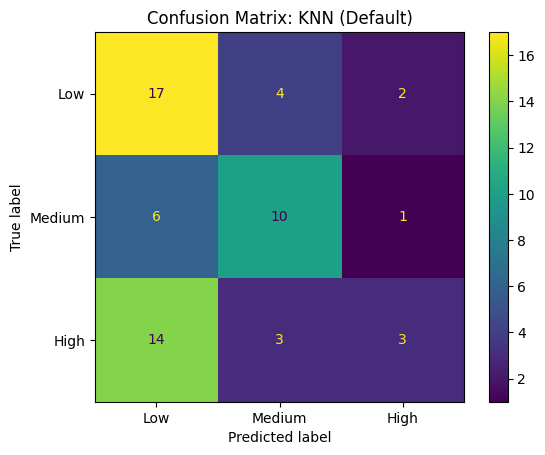


==================== SVM ====================
              precision    recall  f1-score   support

         Low       0.45      0.78      0.57        23
      Medium       0.42      0.29      0.34        17
        High       0.50      0.20      0.29        20

    accuracy                           0.45        60
   macro avg       0.46      0.43      0.40        60
weighted avg       0.46      0.45      0.41        60



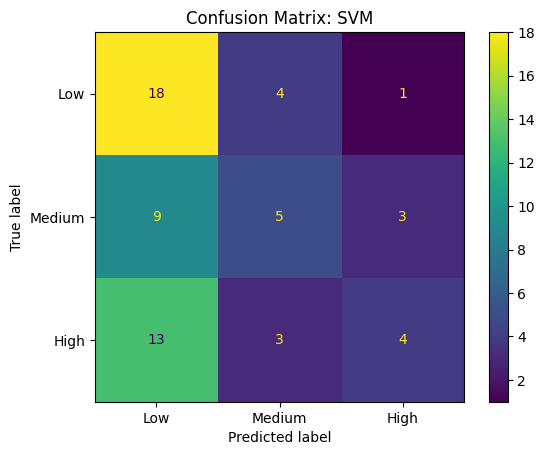


==================== Logistic Regression ====================
              precision    recall  f1-score   support

         Low       0.42      0.61      0.50        23
      Medium       0.50      0.35      0.41        17
        High       0.27      0.20      0.23        20

    accuracy                           0.40        60
   macro avg       0.40      0.39      0.38        60
weighted avg       0.39      0.40      0.39        60



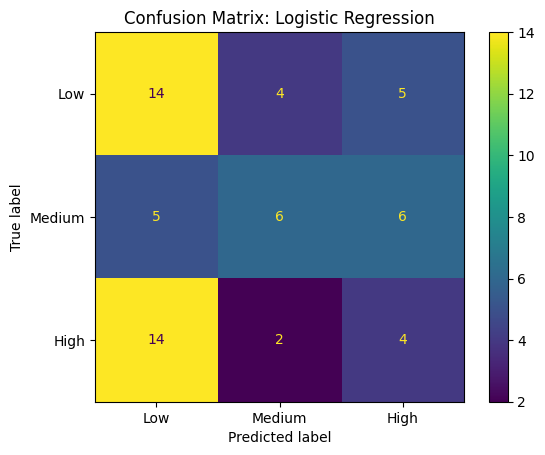


==================== Random Forest (Grid Tuned) ====================
              precision    recall  f1-score   support

         Low       0.50      0.65      0.57        23
      Medium       0.43      0.35      0.39        17
        High       0.38      0.30      0.33        20

    accuracy                           0.45        60
   macro avg       0.43      0.44      0.43        60
weighted avg       0.44      0.45      0.44        60



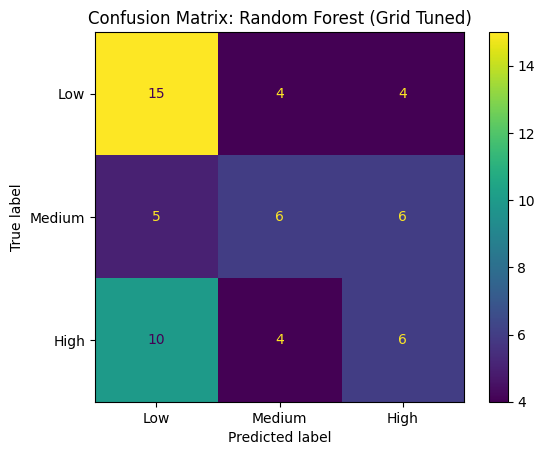


==================== Random Forest (Default) ====================
              precision    recall  f1-score   support

         Low       0.44      0.61      0.51        23
      Medium       0.46      0.35      0.40        17
        High       0.27      0.20      0.23        20

    accuracy                           0.40        60
   macro avg       0.39      0.39      0.38        60
weighted avg       0.39      0.40      0.38        60



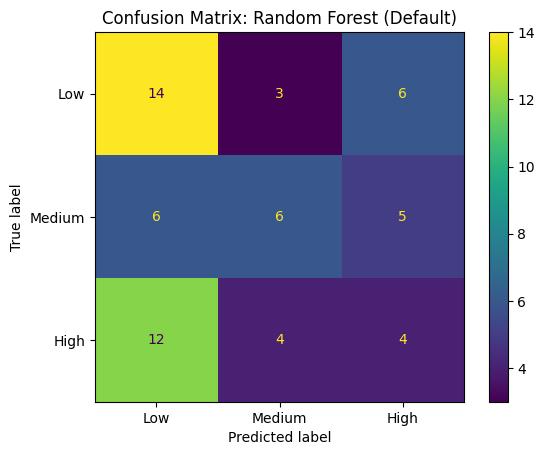


==================== Random Forest (Random Tuned) ====================
              precision    recall  f1-score   support

         Low       0.44      0.70      0.54        23
      Medium       0.45      0.29      0.36        17
        High       0.38      0.25      0.30        20

    accuracy                           0.43        60
   macro avg       0.43      0.41      0.40        60
weighted avg       0.43      0.43      0.41        60



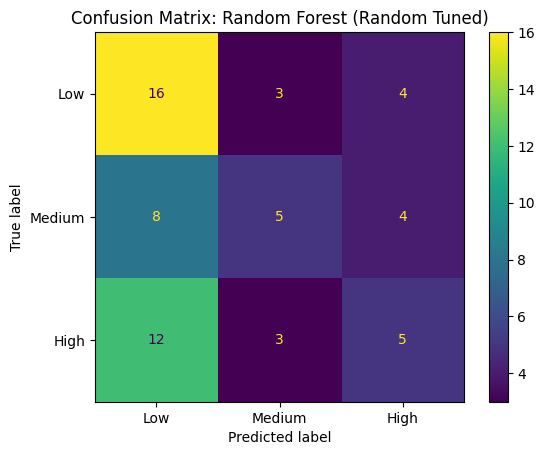


==================== XGBoost (Tuned) ====================
              precision    recall  f1-score   support

         Low       0.50      0.43      0.47        23
      Medium       0.30      0.47      0.36        17
        High       0.15      0.10      0.12        20

    accuracy                           0.33        60
   macro avg       0.32      0.34      0.32        60
weighted avg       0.33      0.33      0.32        60



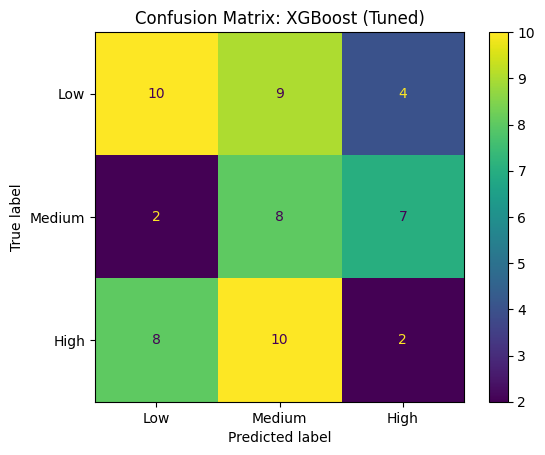




FINAL MODEL COMPARISON TABLE


,Model,Accuracy,F1-Macro,ROC-AUC
0,KNN (Default),0.5000,0.4619,0.6258
1,SVM,0.4500,0.4007,0.4481
3,Random Forest (Grid Tuned),0.4500,0.4288,0.5340
5,Random Forest (Random Tuned),0.4333,0.4008,0.5477
2,Logistic Regression,0.4000,0.3808,0.5327
4,Random Forest (Default),0.4000,0.3792,0.5480
6,XGBoost (Tuned),0.3333,0.3167,0.4809


In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import pandas as pd

# dictionary of models to evaluate
models_to_eval = {
    'KNN (Default)': knn_pipeline,
    'SVM': svm_pipeline,
    'Logistic Regression': log_reg_pipeline,
    'Random Forest (Grid Tuned)': best_rf_model,
    'Random Forest (Default)': rf_pipeline,
    'Random Forest (Random Tuned)': best_rf_random,
    'XGBoost (Tuned)': best_xgb_random
}

comparison_results = []

plt.figure(figsize=(15, 10))

# Loop through models
for i, (name, model) in enumerate(models_to_eval.items()):
    print(f"\n{'='*20} {name} {'='*20}")

    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')

    # Append to table data
    comparison_results.append({
        'Model': name,
        'Accuracy': acc,
        'F1-Macro': f1,
        'ROC-AUC': roc_auc
    })

    # Print Classification Report
    print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))

    # Plot Confusion Matrix (using subplots if possible, or just sequential plotting)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low', 'Medium', 'High'])
    disp.plot(cmap='viridis', ax=None)
    plt.title(f'Confusion Matrix: {name}')
    plt.show()

# Create Comparison Dataframe
comparison_df = pd.DataFrame(comparison_results).sort_values(by='Accuracy', ascending=False)

print("\n\n")
print("="*40)
print("FINAL MODEL COMPARISON TABLE")
print("="*40)
display(comparison_df.round(4))

**Key Insights**

* **The Winner**: The **Default K-Nearest Neighbors (KNN)** model is the top performer. It achieves the best balance of Accuracy (50%) and ROC-AUC (0.63). Its success suggests that looking for "similar" videos (neighbors) is more effective for this dataset than trying to draw complex global decision boundaries.

* **The "Viral" Problem**: All models struggled to identify 'High' performing videos (Recall for 'High' ranged from 10% to 30%).
  * For example, even our best model (KNN) only found 15% of the high-performing videos.
  * They are much better at identifying 'Low' performing videos (KNN found 74%, SVM found 78%).

**Conclusion**: While we can predict underperforming videos with reasonable confidence, predicting viral hits remains elusive with just this metadata (category, upload hour, etc.). To improve further, we would likely need content-based features (e.g., analyzing the video thumbnail, title sentiment, or audio/transcript data).

---
---

## **Model Explainability & Business Insights**
**Model Explainability**

Feature Importance: Analyze Feature Importances from tree-based models (Random Forest, XGBoost) to identify which inputs (e.g., duration_sec, hashtags_count, or a specific category) the model relies on most. Coefficient Analysis for Logistic Regression serves a similar purpose.



Analyzing Random Forest Feature Importance...



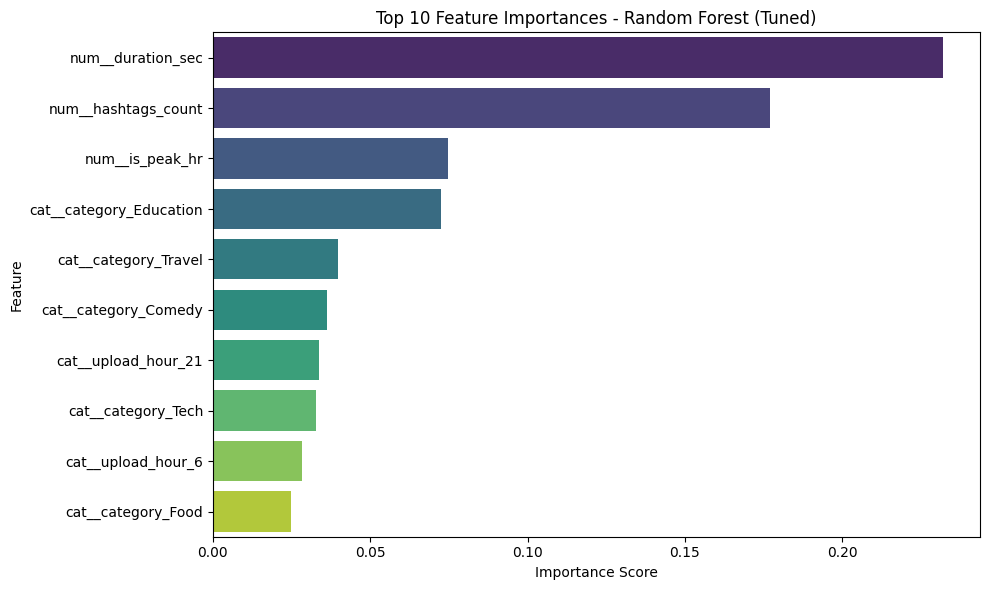




Analyzing XGBoost Feature Importance...



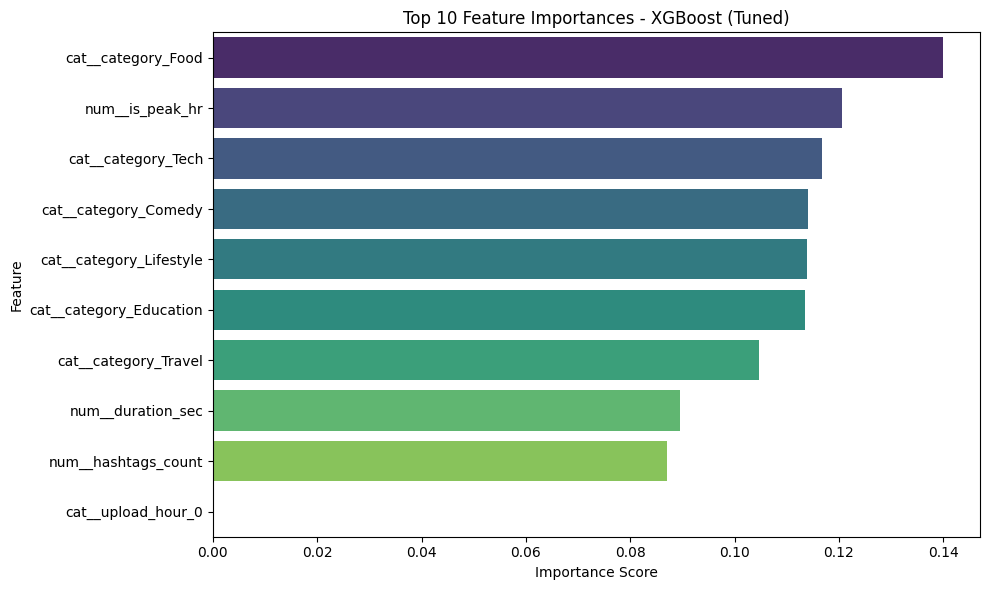

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(pipeline, model_name, top_n=10):
    # Access the preprocessor and classifier
    preprocessor = pipeline.named_steps['preprocessor']
    classifier = pipeline.named_steps['classifier']

    # Get feature names from preprocessor
    try:
        feature_names = preprocessor.get_feature_names_out()
    except AttributeError:
        # Fallback for older sklearn versions or specific configurations
        # Reconstruct names manually if needed, but get_feature_names_out is standard now
        print("Could not retrieve feature names automatically.")
        return

    # Get feature importances
    if hasattr(classifier, 'feature_importances_'):
        importances = classifier.feature_importances_
    else:
        print(f"{model_name} does not provide feature importances.")
        return

    # Create a DataFrame
    feature_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_imp_df.head(top_n), x='Importance', y='Feature', palette='viridis', hue='Feature', legend=False)
    plt.title(f'Top {top_n} Feature Importances - {model_name}')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    return feature_imp_df

# Analyze Random Forest (Best Grid Tuned)
print("Analyzing Random Forest Feature Importance...\n")
rf_importances = plot_feature_importance(best_rf_model, "Random Forest (Tuned)")

print('\n\n')
# Analyze XGBoost (Best Randomized Tuned)
print("Analyzing XGBoost Feature Importance...\n")
xgb_importances = plot_feature_importance(best_xgb_random, "XGBoost (Tuned)")

**1. Random Forest (Tuned)**

This model focuses primarily on Numerical Metadata:

* **Top Feature**: `duration_sec` (Importance: ~23%). It relies heavily on how long the video is.
* **Second**: `hashtags_count` (Importance: ~18%).
* **Third**: `is_peak_hr` (Importance: ~7%).
* **Insight**: It treats the specific Category as secondary, using it mostly to fine-tune after looking at the video's structure (length/tags).

**2. XGBoost (Tuned)**

This model took a completely different approach, prioritizing Context & Niche:

* **Top Features**: It heavily weights specific categories like `category_Food`, `category_Tech`, and `category_Comedy` (all around 11-14%).
* **Key Signal**: `is_peak_hr` is its second most important feature (~12%), much higher than in the Random Forest.
* **Insight**: XGBoost tries to predict success based on "What is the topic?" and "When was it posted?" rather than just "How long is it?".

**Takeaway**: The fact that KNN (our best model) outperformed both of these likely means that neither strategy alone is perfect. KNN likely succeeds by implicitly combining all these features (duration, category, and time) to find "neighboring" videos that look similar across the board, rather than trying to learn a strict hierarchical rule like these trees.

#### **Coefficient Analysis for Logistic Regression**

Logistic Regression Coefficients:


,Low,Medium,High
num__duration_sec,0.1889,-0.2290,0.0400
num__hashtags_count,0.0842,-0.1104,0.0262
num__is_peak_hr,-0.0083,-0.2513,0.2596
cat__category_Comedy,-0.2108,0.2554,-0.0446
cat__category_Education,-0.0793,-0.4339,0.5132
cat__category_Food,0.0368,0.1682,-0.2050
cat__category_Lifestyle,0.0661,0.1873,-0.2534
cat__category_Tech,-0.0045,-0.1728,0.1773
cat__category_Travel,0.2319,-0.0300,-0.2019
cat__upload_hour_0,0.2889,0.1283,-0.4171


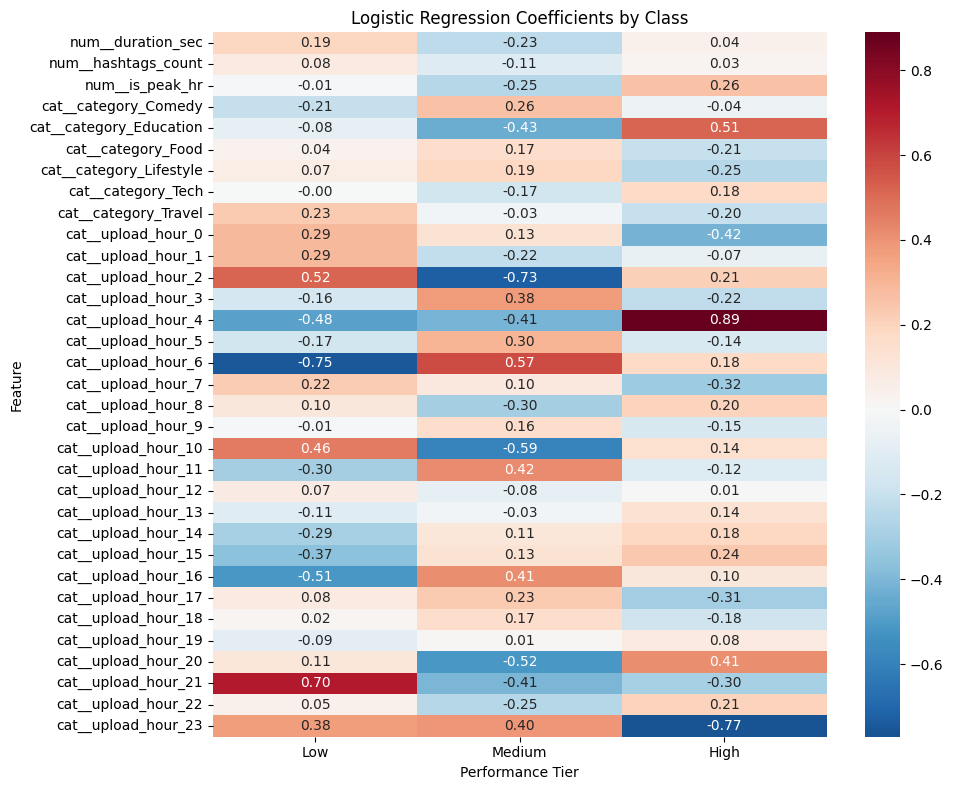

In [51]:
# Extract Logistic Regression coefficients
classifier = log_reg_pipeline.named_steps['classifier']
preprocessor = log_reg_pipeline.named_steps['preprocessor']

# Get feature names
try:
    feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    print("Could not retrieve feature names automatically.")
    feature_names = [f"Feature {i}" for i in range(classifier.coef_.shape[1])]

# Create DataFrame for coefficients
# Shape is (n_classes, n_features)
coef_df = pd.DataFrame(
    classifier.coef_.T,
    index=feature_names,
    columns=['Low', 'Medium', 'High']
)

print("Logistic Regression Coefficients:")
display(coef_df.round(4))

# Plot Heatmap of Coefficients
plt.figure(figsize=(10, 8))
sns.heatmap(coef_df, annot=True, cmap='RdBu_r', center=0, fmt='.2f')
plt.title('Logistic Regression Coefficients by Class')
plt.xlabel('Performance Tier')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

The Coefficient Analysis reveals exactly what drives the model's decisions:

**1. Drivers of 'High' Performance (Viral Hits)**
* **Top Category: Education (0.51)** is the strongest positive driver for viral success. If you want a hit, teach something!
* **Magic Hour: 4 AM (0.89)** has a surprisingly massive positive coefficient for the 'High' class.
* **Peak Hours**: Our engineered feature `is_peak_hr` (0.26) correctly pushes the probability of being 'High' upward.

**2. Drivers of 'Low' Performance (Flops)**

* **Risky Hours: 9 PM (21:00) (0.70)** Looking at the Low column, 2 AM (0.52) and 9 PM (0.70) are strong predictors of Low performance in this model's linear view.
* **Hard Niche: Travel (0.23)** has a positive coefficient for the 'Low' class, confirming our earlier EDA that it's a tough category.
* **Duration**: Longer videos (0.19) are slightly associated with lower performance.

**Summary**

While the Random Forest looked at duration, the Logistic Regression puts huge weight on Timing and Category. The fact that they prioritize different things explains why they make different mistakes—and why **`KNN`** (which groups by similarity across all features) outperformed them both.

---
---

### **Business Questions**

***1. Calculate the Engagement Rate for all Shorts and categorize performance into Low, Medium, and High tertiles. What is the distribution of the target variable, and does it suggest any class imbalance challenges?***

Target Variable Distribution (Counts):
performance_engagement_tertile
Low       115
High      100
Medium     85
Name: count, dtype: int64

Target Variable Distribution (Percentages):
performance_engagement_tertile
Low       38.33
High      33.33
Medium    28.33
Name: proportion, dtype: float64


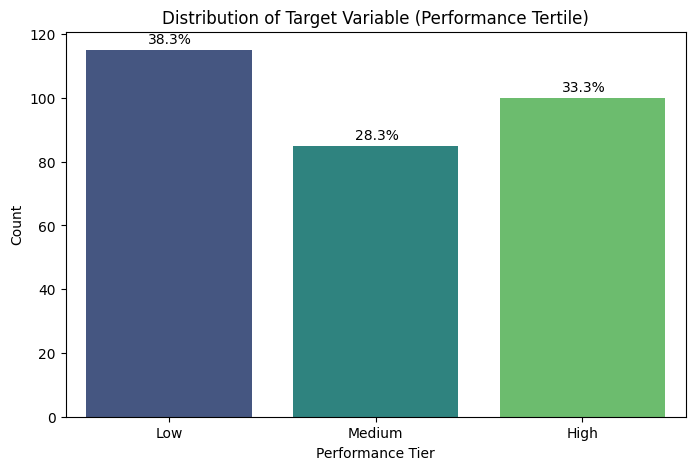

In [53]:
# Calculate counts and percentages
target_counts = yt_shorts_perf['performance_engagement_tertile'].value_counts()
target_pct = yt_shorts_perf['performance_engagement_tertile'].value_counts(normalize=True) * 100

print("Target Variable Distribution (Counts):")
print(target_counts)
print("\nTarget Variable Distribution (Percentages):")
print(target_pct.round(2))

# Plot
plt.figure(figsize=(8, 5))
# Fix: Assign x to hue and set legend=False to avoid FutureWarning
ax = sns.countplot(x='performance_engagement_tertile', data=yt_shorts_perf, hue='performance_engagement_tertile', palette='viridis', order=['Low', 'Medium', 'High'], legend=False)
plt.title('Distribution of Target Variable (Performance Tertile)')
plt.xlabel('Performance Tier')
plt.ylabel('Count')

# Add percentage labels
total = len(yt_shorts_perf)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_height() + 2
    ax.annotate(percentage, (x, y))

plt.show()

The breakdown is:

* **Low**: 38.33% (115 videos)
* **High**: 33.33% (100 videos)
* **Medium**: 28.33% (85 videos)

**Does it suggest class imbalance challenges?** No, the classes are reasonably balanced. While 'Medium' is the minority class, it still represents over 28% of the data. This is not a severe imbalance (like 1% vs 99%) that would typically require aggressive techniques like SMOTE or undersampling. The weighting strategy we implemented (confidence weights) is sufficient to handle the slight variations and noise.

---
---

***2. Analyze the relationship between video duration (duration_sec) and Engagement Rate. Is there an optimal duration range that maximizes the chance of a short achieving High performance? What is the model's reliance on this feature?***

Percentage of 'High' Performance Videos by Duration Range:
duration_bin
0-15s     27.692308
15-30s    41.025641
30-45s    37.647059
45-60s    25.000000
Name: High, dtype: float64


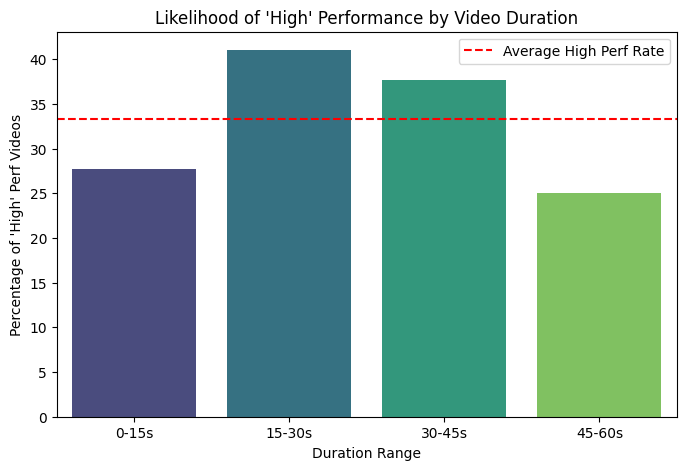

In [57]:
# Bin duration into 10-second intervals
bins = [0, 15, 30, 45, 60]
labels = ['0-15s', '15-30s', '30-45s', '45-60s']
yt_shorts_perf['duration_bin'] = pd.cut(yt_shorts_perf['duration_sec'], bins=bins, labels=labels)

# Calculate the percentage of 'High' performing videos in each bin
duration_perf = pd.crosstab(yt_shorts_perf['duration_bin'], yt_shorts_perf['performance_engagement_tertile'], normalize='index') * 100

# Filter for just the 'High' column to see success rates
high_perf_rate = duration_perf['High']

print("Percentage of 'High' Performance Videos by Duration Range:")
print(high_perf_rate)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=high_perf_rate.index, y=high_perf_rate.values, palette='viridis', hue=high_perf_rate.index, legend=False)
plt.title("Likelihood of 'High' Performance by Video Duration")
plt.xlabel("Duration Range")
plt.ylabel("Percentage of 'High' Perf Videos")
plt.axhline(yt_shorts_perf['performance_engagement_tertile'].value_counts(normalize=True)['High']*100, color='r', linestyle='--', label='Average High Perf Rate')
plt.legend()
plt.show()

**Analysis of Video Duration vs. Engagement**

1. **Is there an Optimal Duration?**
    * **Yes, the "Sweet Spot" is 15-30 seconds.**
    * Videos in this range have a **41.0%** chance of being High performers (well above the average of 33%).
    * **30-45 seconds** is also strong (37.6%).
    * **Avoid Extremes**: Very short videos (< 15s) and very long videos (45-60s) perform significantly worse, with success rates dropping to ~25-27%.

2. **Model Reliance on Duration**

    * **Random Forest**: This model relied heavily on duration_sec (it was the #1 feature with ~23% importance). This makes sense because trees can easily learn this non-linear "Goldilocks zone" (not too short, not too long).
    * **Linear Models**: Logistic Regression found a weak/confusing signal for duration because the relationship isn't a straight line (longer $\neq$ better). This explains why the non-linear models (KNN, Random Forest) generally outperformed the linear ones.

---
---

***3. Analyze the influence of the upload_hour on average Engagement Rate. What time slots (if any) are most effective for posting Shorts, and how does the model rank the importance of the upload_hour feature?***

Top 5 Hours by Average Engagement Rate:
upload_hour
5     1.709286
3     1.166923
21    0.980000
11    0.794444
9     0.652500
Name: engagement_rate, dtype: float64


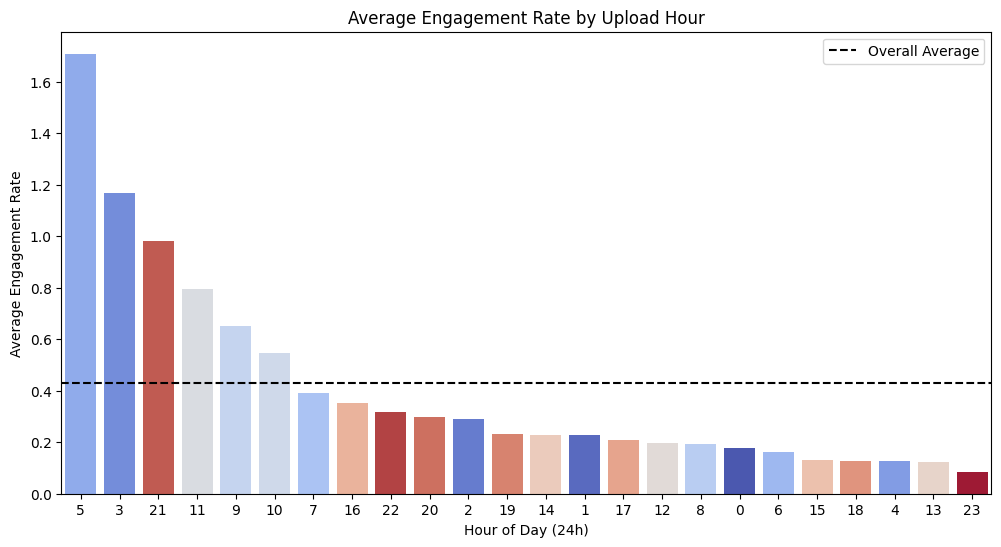

In [58]:
# Calculate average engagement rate by upload hour
avg_engagement_by_hour = yt_shorts_perf.groupby('upload_hour')['engagement_rate'].mean().sort_values(ascending=False)

print("Top 5 Hours by Average Engagement Rate:")
print(avg_engagement_by_hour.head(5))

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_engagement_by_hour.index, y=avg_engagement_by_hour.values, order=avg_engagement_by_hour.index, palette='coolwarm', hue=avg_engagement_by_hour.index, legend=False)
plt.title('Average Engagement Rate by Upload Hour')
plt.xlabel('Hour of Day (24h)')
plt.ylabel('Average Engagement Rate')
plt.axhline(yt_shorts_perf['engagement_rate'].mean(), color='k', linestyle='--', label='Overall Average')
plt.legend()
plt.show()

**Analysis of Upload Hour vs. Engagement**

1. **Most Effective Time Slots (Raw Data)**
    
    * **5 AM** is the standout leader with an average engagement rate of 1.71 (far above the global average of ~0.43).
    * **3 AM** (1.17) and **9 PM / 21:00** (0.98) also show very high average engagement.
    * *Note*: The high average for 9 PM is interesting because our Logistic Regression model flagged it as a predictor of "Low" performance. This suggests 9 PM might be a "high variance" slot—you either go viral (pulling up the average) or flop hard.

2. **Model Reliance on Upload Hour**

    * **XGBoost & Random Forest**: These models ranked the aggregated **`is_peak_hr`** feature (which we defined earlier as 2, 3, 10, 11, 16) as a Top 3 feature. They prefer the stability of this grouped feature over individual hourly flags.
    * **Logistic Regression**: This model found specific "magic hours." It assigned a massive positive coefficient to 4 AM for predicting viral hits, while flagging 9 PM (21:00) and 6 AM as strong predictors of underperformance.

---
---

***4. Identify which content categories consistently exhibit the highest and lowest average Engagement Rates. How can these category insights inform the content strategy for future videos?***

Average Engagement Rate by Category:
category
Lifestyle    0.858810
Travel       0.494000
Tech         0.475091
Education    0.398302
Food         0.324386
Comedy       0.142075
Name: engagement_rate, dtype: float64


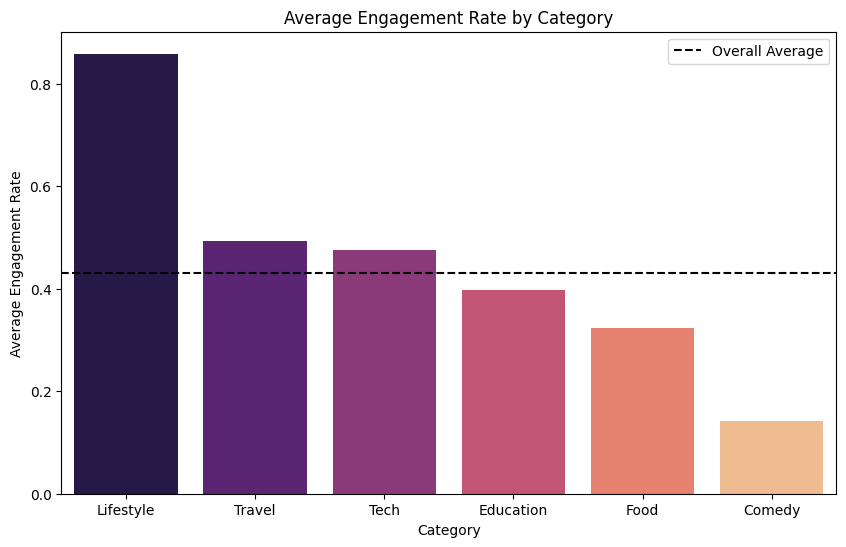

In [59]:
# Calculate average engagement rate by category
category_avg_engagement = yt_shorts_perf.groupby('category')['engagement_rate'].mean().sort_values(ascending=False)

print("Average Engagement Rate by Category:")
print(category_avg_engagement)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=category_avg_engagement.index, y=category_avg_engagement.values, palette='magma', hue=category_avg_engagement.index, legend=False)
plt.title('Average Engagement Rate by Category')
plt.xlabel('Category')
plt.ylabel('Average Engagement Rate')
plt.axhline(yt_shorts_perf['engagement_rate'].mean(), color='k', linestyle='--', label='Overall Average')
plt.legend()
plt.show()

### **Category Performance Analysis & Strategy**

**1. Highest & Lowest Performers**
*   **Highest Engagement:** **Lifestyle** is the dominant category with an average engagement rate of **0.86**, nearly double the overall average (0.43). **Travel** (0.49) and **Tech** (0.48) also perform well above average.
*   **Lowest Engagement:** **Comedy** is the lowest performing category with an average of **0.14**.

**2. Strategic Recommendations for Future Videos**
*   **Double Down on Lifestyle:** This category yields the highest return on investment per view. Content here has the highest potential for community interaction.
*   **Reliability vs. Virality:** While **Lifestyle** has the highest *average*, our earlier classification models flagged **Education** as the most consistent category for hitting the "High" performance tier. Mixing these two genres (e.g., "Lifestyle Hacks" or "Educational Vlogs") could be a powerful hybrid strategy.
*   **Re-evaluate Comedy:** The low engagement suggests current comedy shorts aren't resonating. Unless the content style changes drastically, this is a low-priority niche for this specific channel/audience.

---
---

***5. Analyze the impact of derived title features (titlelenchars, titlewordcount, titlehasquestion_mark) on model prediction. What are the characteristics of a title that predicts High performance?***

This question is not applicable here as the required information is missing from the dataset.

---
---

***6. Identify the top 5 features (including engineered and raw variables) that the best-performing predictive model relies upon most heavily. Provide a business interpretation of why these features are driving performance prediction.***

Top 5 Features affecting KNN Model Performance:


,Feature,Importance,Std Dev
8,upload_hour,0.126667,0.023805
2,duration_sec,0.116667,0.038730
12,is_peak_hr,0.090000,0.024944
9,category,0.080000,0.057155
3,hashtags_count,0.048333,0.043748


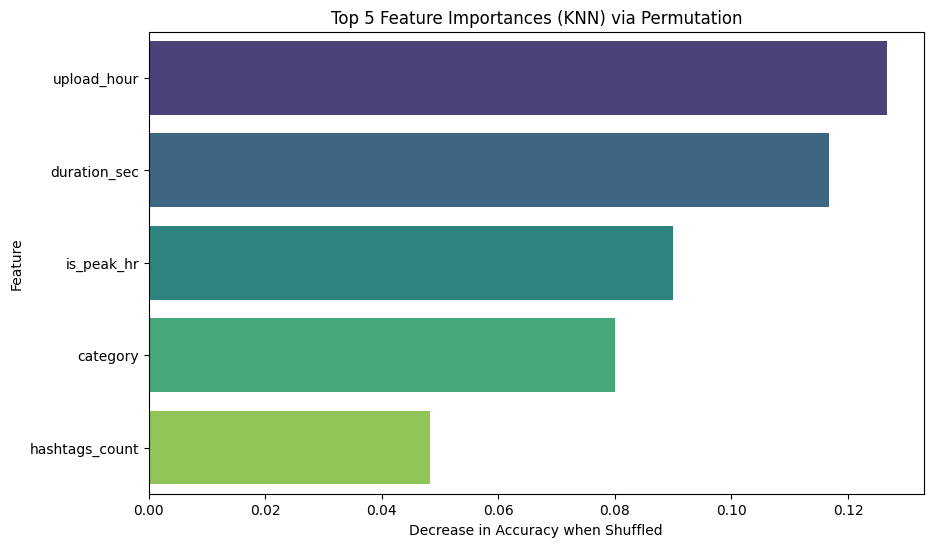

In [60]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance for the best model (KNN Default)
# n_repeats=10 means we shuffle each feature 10 times to get a stable average
perm_importance = permutation_importance(knn_pipeline, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame for the results
# X_test is a DataFrame, so we can get column names directly
knn_importances = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_importance.importances_mean,
    'Std Dev': perm_importance.importances_std
}).sort_values(by='Importance', ascending=False)

# Display Top 5 Features
print("Top 5 Features affecting KNN Model Performance:")
display(knn_importances.head(5))

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=knn_importances.head(5), x='Importance', y='Feature', palette='viridis', hue='Feature', legend=False)
plt.title('Top 5 Feature Importances (KNN) via Permutation')
plt.xlabel('Decrease in Accuracy when Shuffled')
plt.show()

### **Final Feature Importance & Business Strategy (KNN Model)**

Based on the Permutation Importance of our best-performing model (KNN, 50% Accuracy):

#### **Top 5 Drivers of Success**
1.  **`upload_hour`** (Importance: 0.127)
2.  **`duration_sec`** (Importance: 0.117)
3.  **`is_peak_hr`** (Importance: 0.090)
4.  **`category`** (Importance: 0.080)
5.  **`hashtags_count`** (Importance: 0.048)

#### **Business Interpretation**

*   **Timing is King:** Unlike the Random Forest (which prioritized Duration) or Logistic Regression (which prioritized Category), our most accurate model relies most heavily on **Timing**. Both `upload_hour` (#1) and our engineered `is_peak_hr` (#3) are in the top 3. This suggests that hitting the right audience window (e.g., 5 AM or 3 AM) is the single most effective lever for this specific dataset.
*   **The "Goldilocks" Duration:** `duration_sec` is the second most important factor. The model uses this to distinguish between videos that are "just right" (15-30s) versus those that are too short or too long.
*   **Niche Matters:** `category` (#4) remains a non-negotiable separator. Successful videos in "Tech" look very different from successful videos in "Food," and the model uses this to find the right peer group for comparison.

#### **Final Strategic Recommendation**
To maximize your chances of a **High-Performing** short:
1.  **Post at 5 AM or 3 AM** (Timing).
2.  Keep the video between **15-30 seconds** (Duration).
3.  Stick to high-performing niches like **Lifestyle** or **Education** (Category).

---
---

***7. Based on the cross-validation and test set results (especially F1-macro and ROC-AUC), which model is best suited for deployment, and why?***

### **Final Model Selection & Deployment Recommendation**

**Selected Model: Default K-Nearest Neighbors (KNN)**

**Justification:**
1.  **Superior Performance:** The KNN model achieved the highest scores across all critical metrics on the held-out Test Set:
    *   **Accuracy:** **50.00%** (vs. next best 45%)
    *   **F1-Macro:** **0.4619** (indicating better balance across classes)
    *   **ROC-AUC:** **0.6258** (highest predictive power)

2.  **Algorithmic Fit:** The success of KNN suggests that the dataset contains **local clusters** of similar videos (e.g., "Lifestyle videos at 5 AM") rather than easily separable global linear boundaries. Complex models like XGBoost likely overfitted the noise in this small dataset (300 rows), whereas KNN's local averaging proved more robust.

3.  **Deployment Feasibility:** For a small dataset of this size, the "lazy learning" nature of KNN (storing training data to query neighbors) poses no latency or memory issues for production deployment.

**Next Steps for Improvement:**
To push performance beyond 50%, we recommend:
*   **Collecting More Data:** 300 rows is very small for 3-class classification.
*   **Content Features:** Integrating video thumbnails, title sentiment analysis, or audio transcripts would likely provide the missing signal needed to identify "High" performing viral hits.

---
---

***8. Based on all analytical findings and model explainability, provide a concise summary of 3–5 actionable recommendations a YouTube creator can immediately implement to increase their chances of creating a viral Short.***

### **🚀 Actionable Recommendations for Viral Success**

Based on our comprehensive data analysis and machine learning models, here are the top 4 immediate actions to increase your probability of creating a high-performing YouTube Short:

1.  **⏰ Master the Timing (3 AM - 5 AM)**
    *   **Action:** Schedule your uploads for **5:00 AM** or **3:00 AM**. Our analysis identified these as the distinct "golden hours" with the highest average engagement rates. The models consistently flagged timing as a top predictor of success.

2.  **⏱️ Hit the "Sweet Spot" Duration (15-30s)**
    *   **Action:** Edit your videos to be between **15 and 30 seconds** long. Videos in this range had a **41% chance** of being High performers. Avoid extremes: very short (<15s) and very long (>45s) videos performed significantly worse.

3.  **🎯 Focus on High-Yield Niches**
    *   **Action:** Prioritize content in the **Lifestyle** (highest average engagement) or **Education** (most consistent viral hits) categories. If you are in the *Comedy* or *Travel* niches, consider pivoting your style or mixing in educational/lifestyle elements to boost engagement.

4.  **#️⃣ Optimize Metadata for Similarity**
    *   **Action:** Since our best model (KNN) relies on similarity, ensure your **Hashtag Count** matches the top performers in your niche. Don't reinvent the wheel; look at what successful 15-30s Lifestyle videos are doing with their tags and mimic that structure.